# Summary

Evaluate a trained network on a [TIM barrel](https://pfam.xfam.org/clan/TIM_barrel) protein.

---

# Imports

In [192]:
%run _imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Setting the PACKAGE_VERSION environment variable.
Setting the DOCS_SECRET_KEY environment variable.
Setting the PYTHON_VERSION environment variable.
Setting the SPARK_MASTER environment variable.
Setting the SPARK_ARGS environment variable.
Setting the DB_TYPE environment variable.
Setting the DB_PORT environment variable.


2018-04-25 16:26:15.336072


In [193]:
import io
from typing import NamedTuple

import Bio.SeqIO
import torch

In [194]:
import kmtools.sequence_tools

In [195]:
import pagnn

# Parameters

In [196]:
NOTEBOOK_NAME = 'evaluate_tim_barrel'
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).absolute()

NOTEBOOK_PATH.mkdir(parents=True, exist_ok=True)

In [197]:
DATABIN_PATH = Path(os.environ['DATABIN_DIR'])

In [198]:
PDB_ID = '1vkf'
PDB_PATH = NOTEBOOK_PATH.joinpath(PDB_ID + '.cif')

# Prepare dataset

## Extract sequence and adjacency from PDB

In [199]:
structure = kmbio.PDB.load(f'rcsb://{PDB_ID}.cif', structure_id=0)

The following exception occured: ''! Failed!


KeyboardInterrupt: 

In [ ]:
from kmtools import structure_tools


def get_interaction_dataset(structure_file, R_CUTOFF):
    """Copied from "datapkg/pdb-analysis/notebooks/extract_pdb_interactions.ipynb"
    """
    try:
        structure = kmbio.PDB.load(structure_file, bioassembly_id=1, use_auth_id=False)
        bioassembly_id = 1
    except (kmbio.PDB.exceptions.BioassemblyError, KeyError) as e:
        logger.info("Could not construct bioassembly for file '%s'", structure_file)
        structure = kmbio.PDB.load(structure_file, bioassembly_id=0, use_auth_id=False)
        bioassembly_id = 0

    interactions = structure_tools.get_interactions(structure, r_cutoff=R_CUTOFF, interchain=True)
    interactions_core, interactions_interface = structure_tools.process_interactions(interactions)

    # Group interactions by chain / chan pair
    interactions_core_aggbychain = structure_tools.process_interactions_core(
        structure, interactions_core)
    interactions_interface_aggbychain = structure_tools.process_interactions_interface(
        structure, interactions_interface)

    # Drop duplicate rows?
    interactions_core, interactions_core_aggbychain = \
        structure_tools.drop_duplicates_core(interactions_core, interactions_core_aggbychain)
    interactions_interface, interactions_interface_aggbychain = \
        structure_tools.drop_duplicates_interface(interactions_interface,
                                                  interactions_interface_aggbychain)

    return (interactions_core, interactions_core_aggbychain, interactions_interface,
            interactions_interface_aggbychain, bioassembly_id)

In [ ]:
kmbio.PDB.core.atom.logger.setLevel(logging.WARNING)

In [ ]:
R_CUTOFF = 5

df = get_interaction_dataset(PDB_PATH, R_CUTOFF)

In [ ]:
df[0].head()

In [ ]:
df[1]

In [ ]:
adjacency_df = df[1].copy()

In [ ]:
adjacency_df['residue_idx_1_corrected'] = pd.Series(
    adjacency_df['residue_pair'].apply(lambda lst: [t[0] for t in lst]))
adjacency_df['residue_idx_2_corrected'] = pd.Series(
    adjacency_df['residue_pair'].apply(lambda lst: [t[1] for t in lst]))

In [ ]:
adjacency_df = adjacency_df.drop('residue_pair', axis=1)

In [ ]:
adjacency_df.head()

In [ ]:
pq.write_table(
    pa.Table.from_pandas(
        adjacency_df.rename(columns={
            'protein_sequence': 'sequence',
            'residue_idx_1_corrected': 'adjacency_idx_1',
            'residue_idx_2_corrected': 'adjacency_idx_2',
        }),
        preserve_index=False,
    ),
    NOTEBOOK_PATH.joinpath(f'{PDB_ID}_adjacencies.parquet'),
    version='2.0', flavor='spark'
)

## Run PSIPRED on hhblits results

In [ ]:
# Load hhblits alignment
seqs = list(Bio.SeqIO.parse(f'{NOTEBOOK_NAME}/1vkf0A.fas', format='fasta'))

seq_ref = str(seqs[0].seq)
seqs_target = [str(s.seq) for s in seqs[1:]]

seqs_target = [''.join(st for sr, st in zip(seq_ref, s) if sr != '-') for s in seqs_target]
seq_ref = ''.join(s for s in seq_ref if s != '-')

assert all(len(s) == len(seq_ref) for s in seqs_target)

In [ ]:
os.getenv('SLURM_TMPDIR')

In [ ]:
from itertools import repeat
from kmtools import sequence_tools


def run_psipred(idx, sequence, hhblits_database, tmp_dir):
    fasta_file = Path(tmp_dir).joinpath(f'seq_{idx}.fasta')
    with fasta_file.open('wt') as fout:
        fout.write(f'> seq_{idx}\n')
        fout.write(sequence + '\n')
    psipred_file = sequence_tools.run_psipred(fasta_file, hhblits_database)
    psipred = sequence_tools.read_psipred(psipred_file)
    return psipred


def add_secondary_structure(seqs, hhblits_database):
    with concurrent.futures.ProcessPoolExecutor() as p, \
            tempfile.TemporaryDirectory() as tmp_dir:
        sequence_ss = list(
            p.map(run_psipred, range(len(seqs)), seqs, repeat(hhblits_database),
                  repeat(tmp_dir)))
    return sequence_ss

In [ ]:
hhblits_database = Path('/home/strokach/databin/hh-suite/uniprot20_2016_02')

In [14]:
sequence_ss = add_secondary_structure(seqs_target, hhblits_database)

In [17]:
with NOTEBOOK_PATH.joinpath('1vkf0A.ss.pickle').open('wb') as fout:
    pickle.dump(sequence_ss, fout, pickle.HIGHEST_PROTOCOL)

In [32]:
buffer = ''

for seq, ss in zip(seqs[1:], sequence_ss):
    buffer += f'> {seq.id}\n{ss}\n'

with NOTEBOOK_PATH.joinpath('1vkf0A.ss.fasta').open('wt') as fout:
    fout.write(buffer)

In [33]:
!head {NOTEBOOK_PATH.joinpath('1vkf0A.ss.fasta')}

> tr|B9K8F1|B9K8F1_THENN
CCCCEEEEECCHHHHHHCCCCEEEEECCCHHHHHHHHHHHHHCCCEEEEEECCCCCCCCCHHHHHHHHHHCCCEEEECCHHHHHHHHHCCCEEEEEEEECCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
> tr|A0A081NZG8|A0A081NZG8_9BACL
CCCCEEEEECCHHHHHHCCCCEEEEECCCHHHHHHHHHHHHHCCCEEEEEEHHCCCCCCCHHHHHHHHHHCCCEEEECCHHHHHHHHHCCCEEEEEHHHCCHHHHHHHHHHHHCCCCCEEEEECHHCHHHHHHHHCCCCEEEECCCCCHHHHHHHHHCCEEEECCCHHHHCC
> tr|A0A0C2V0J0|A0A0C2V0J0_9BACL
CCCCEEEEECCHHHHHHCCCCEEEEECCCHHHHHHHHHHHHHCCCEEEEEEECCCCCCCCHHHHHHHHHHCCCEEEECCHHHHHHHHHCCCEEEEEHHHHHHHHHHHHHHHHHCCCCCEEEECCCCCHHHHHHHHCCCCEEEECCCCCHHHHHHHHHHCCEEECCCHHHHCC
> tr|A0A0P9DC63|A0A0P9DC63_9BACL
CCCCEEEEECCHHHHHHCCCCEEEEECCCHHHHHHHHHHHHHCCCEEEEEEHHCCCCCCCHHHHHHHHHHCCCEEEECCHHHHHHHHHCCCEEEEEHHHCCHHHHHHHHHHHHCCCCCEEEEECHHCHHHHHHHHCCCCEEEECCCCCHHHHHHHHHCCEEEECCCHHHHCC
> tr|A0A0Q4RB39|A0A0Q4RB39_9BACL
CCCCEEEEECCHHHHHHCCCCEEEEECCCHHHHHHHHHHHHHCCCEEEEEEECCCCCCCCHHHHHHHHHHCCCEEEECCHHHHHHHHHCCCEEEEEEEEEEHHHHHHHHHHHHHCCCCEEEECCHHCHHHHHHHHCCCCEEEECCCCCHHH

In [34]:
!tail {NOTEBOOK_PATH.joinpath('1vkf0A.ss.fasta')}

> tr|F0GJ68|F0GJ68_9BURK
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCHHHHHHHHHHHCCCEEECCCCCCHHHHHHHHCCCEEEECCCHHHHCC
> tr|F3NZY0|F3NZY0_9ACTN
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCHHHHHHHHHCCCCCEEECCCCCCHHHHHHHHHCCCEEECCCHHHHCC
> tr|E4HM22|E4HM22_9ACTN
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCHHHHHHHHHCCCCCEEECCCCCCHHHHHHHHHCCCEEECCCHHHHCC
> tr|W1B0Q1|W1B0Q1_KLEPN
CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCHHHHHHHHHCCCCCEEECCCCCCHHHHHHHHHCCCEEECCCHHHHCC
> tr|W7BJB7|W7BJB7_9LIST
CCCCCCCCCCCCCCCCCCCCCEEEEECCCHHHHHHHHHHHHHCCCEEEEECCCCCCCCCCHHHHHHHHHCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


# Run jobs

**To do: this should be done using array jobs!!!**

## `validation_0`

This is done using the old model.

In [ ]:
JOB_ID = 'validation_0'
NOTEBOOK_PATH.joinpath(JOB_ID).mkdir(parents=True, exist_ok=True)

In [ ]:
%%file {NOTEBOOK_NAME}/{JOB_ID}/slurm.sh
#!/bin/bash
#SBATCH --time=3:00:00
#SBATCH --nodes=1
#SBATCH --exclusive
#SBATCH --mem=0
#SBATCH --account=rrg-pmkim
#SBATCH --job-name=pagnn-validation
#SBATCH --export=ALL

set -ev

unset XDG_RUNTIME_DIR

if [[ -z ${MY_JOB_IDX} ]] ; then
    echo "MY_JOB_IDX environment variable has to be set!"
    exit 1
fi

python ~/working/pagnn/pagnn/prediction/gan/validation.py \l
    --input-file ../1vkf_adjacencies.parquet \
    --output-file ./job_${MY_JOB_IDX}.parquet \
    --work-path ~/datapkg/adjacency-net/notebooks/train_neural_network/gan-permute-seq-0-test_x12-0.1.9.dev-4a07eef/ \
    --step 5900 \
    --include-ss \
    --nseqs 1000

In [ ]:
# for i in range(5, 100):
#     proc = subprocess.run(
#         ['sbatch', 'slurm.sh'],
#         stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True, check=True,
#         cwd=NOTEBOOK_PATH.joinpath(JOB_ID).resolve(),
#         env={**os.environ, 'MY_JOB_IDX': str(i)},
#     )
#     print(f"Job: {i}")
#     print(proc.stdout.strip())
#     print(proc.stderr.strip())
#     print()
#     time.sleep(0.2)

## `validation_1`

Best sequence from a repeating batch size of 256.

In [260]:
JOB_ID = 'validation_1'
NOTEBOOK_PATH.joinpath(JOB_ID).mkdir(parents=True, exist_ok=True)

In [261]:
%%file {NOTEBOOK_NAME}/{JOB_ID}/slurm.sh
#!/bin/bash
#SBATCH --time=3:00:00
#SBATCH --nodes=1
#SBATCH --exclusive
#SBATCH --mem=0
#SBATCH --account=rrg-pmkim
#SBATCH --job-name=pagnn-validation
#SBATCH --constraint=broadwell
#SBATCH --export=ALL
#SBATCH --array=1-100

set -ev

unset XDG_RUNTIME_DIR

if [[ -z ${SLURM_ARRAY_TASK_ID} ]] ; then
    echo "MY_JOB_IDX environment variable has to be set!"
    exit 1
fi

python ~/working/pagnn/pagnn/prediction/gan/validation.py \
    --input-file ../1vkf_adjacencies.parquet \
    --output-file ./job_${SLURM_ARRAY_TASK_ID}.parquet \
    --work-path ~/datapkg/adjacency-net/notebooks/train_neural_network/permute-seq-0-test_x14-0.1.9.dev-4a07eef/ \
    --step 12462 \
    --include-ss \
    --nseqs 1000 \
    --batch-size 256

Writing evaluate_tim_barrel/validation_1/slurm.sh


In [262]:
!chmod +x {NOTEBOOK_NAME}/{JOB_ID}/slurm.sh

In [263]:
# !(cd {NOTEBOOK_NAME}/{JOB_ID}; SLURM_ARRAY_TASK_ID=0 ./slurm.sh)

In [264]:
# !(cd {NOTEBOOK_NAME}/{JOB_ID}; sbatch ./slurm.sh)

Submitted batch job 7303768


## `validation_2`

Batch size of 1.

In [293]:
JOB_ID = 'validation_2'
NOTEBOOK_PATH.joinpath(JOB_ID).mkdir(parents=True, exist_ok=True)

In [257]:
%%file {NOTEBOOK_NAME}/{JOB_ID}/slurm.sh
#!/bin/bash
#SBATCH --time=3:00:00
#SBATCH --nodes=1
#SBATCH --exclusive
#SBATCH --mem=0
#SBATCH --account=rrg-pmkim
#SBATCH --job-name=pagnn-validation
#SBATCH --constraint=broadwell
#SBATCH --export=ALL
#SBATCH --array=1-100

set -ev

unset XDG_RUNTIME_DIR

if [[ -z ${SLURM_ARRAY_TASK_ID} ]] ; then
    echo "MY_JOB_IDX environment variable has to be set!"
    exit 1
fi

python ~/working/pagnn/pagnn/prediction/gan/validation.py \
    --input-file ../1vkf_adjacencies.parquet \
    --output-file ./job_${SLURM_ARRAY_TASK_ID}.parquet \
    --work-path ~/datapkg/adjacency-net/notebooks/train_neural_network/permute-seq-0-test_x14-0.1.9.dev-4a07eef/ \
    --step 12462 \
    --include-ss \
    --nseqs 1000 \
    --batch-size 1

Writing evaluate_tim_barrel/validation_2/slurm.sh


In [258]:
!chmod +x {NOTEBOOK_NAME}/{JOB_ID}/slurm.sh

In [ ]:
# !(cd {NOTEBOOK_NAME}/{JOB_ID}; SLURM_ARRAY_TASK_ID=0 ./slurm.sh)

In [259]:
# !(cd {NOTEBOOK_NAME}/{JOB_ID}; sbatch ./slurm.sh)

Submitted batch job 7303767


## `validation_3`

Batch size of 256 with 255 randomly-chosen control sequences.

In [333]:
JOB_ID = 'validation_3'
NOTEBOOK_PATH.joinpath(JOB_ID).mkdir(parents=True, exist_ok=True)

In [499]:
%%file {NOTEBOOK_NAME}/{JOB_ID}/slurm.sh
#!/bin/bash
#SBATCH --time=3:00:00
#SBATCH --nodes=1
#SBATCH --exclusive
#SBATCH --mem=0
#SBATCH --account=rrg-pmkim
#SBATCH --job-name=pagnn-validation
#SBATCH --constraint=broadwell
#SBATCH --export=ALL
#SBATCH --array=101-101
set -ev

unset XDG_RUNTIME_DIR

if [[ -z ${SLURM_ARRAY_TASK_ID} ]] ; then
    echo "MY_JOB_IDX environment variable has to be set!"
    exit 1
fi

python ~/working/pagnn/pagnn/prediction/gan/validation_batch.py \
    --input-file ../1vkf_adjacencies.parquet \
    --output-file ./job_${SLURM_ARRAY_TASK_ID}.parquet \
    --work-path ~/datapkg/adjacency-net/notebooks/train_neural_network/permute-seq-0-test_x14-0.1.9.dev-4a07eef/ \
    --step 12462 \
    --include-ss \
    --nseqs 1000 \
    --batch-size 256 \
    --validation-dataset-file ../../train_neural_network/validation_gan_exact_80_1000.pickle

Overwriting evaluate_tim_barrel/validation_3/slurm.sh


In [500]:
!chmod +x {NOTEBOOK_NAME}/{JOB_ID}/slurm.sh

In [501]:
# !(cd {NOTEBOOK_NAME}/{JOB_ID}; SLURM_ARRAY_TASK_ID=0 ./slurm.sh)

In [502]:
# !(cd {NOTEBOOK_NAME}/{JOB_ID}; sbatch ./slurm.sh)

Submitted batch job 7334526


# Collect results

In [687]:
JOB_ID

'validation_3'

## Load data

In [688]:
dfs = []
for i in range(1, 102):
    try:
        df = pq.read_table(NOTEBOOK_PATH.joinpath(JOB_ID).joinpath(f'job_{i}.parquet')).to_pandas()
    except pa.ArrowIOError:
        print(f'not found: {i}')
        continue
    dfs.append(df)

not found: 98


In [689]:
len(dfs)

100

In [690]:
reference = dfs[0].iloc[0]

In [691]:
predictions = pd.concat([
    df.iloc[1:] for df in dfs
])

In [692]:
display(predictions.head())
print(len(predictions))

,discriminator_score,blosum62_score,edit_score,sequence,sequence_type,sequence_ss
1,0.113206,-0.744186,0.093023,RRCMRVLAADLALAMAAAPRLAAALDLALAMAAELRMRMARVAGDMLAAMCPDRMMRVLADRLAAELADRMAAEARLAAALLSANAEANAPGAAALLPLALAMAAAPGLAAALLLA...,gen,CHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCCCCCHHHHHHHHHHHHCCCCHHHHHHHH...
2,0.019018,-0.540698,0.093023,RRCMRVLAAAARRAAFNLSARAARNLDRAAAALPLAAAAAAAPGLAAALLPRAAAANQPRAAAANQPRAAAANGLALAMAAGLADRFAADLALRMAAEAGLAAALPLALAEANAPG...,gen,CHHHHHHHHHHHHHHHCHHHHHHHHHHHHHHHCCHHHHHHCCCCHHHHHCHHHHHCCCCHHHHCCCCHHHHHCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCHHHHHHCCCCH...
3,0.005526,-0.686047,0.075581,RRCMRVLAAAARRAAANLPRRAAMNLSARAARNLPRAAAFNLSAAAAANAPRAAARNFPRRGGFNLLAAAAANDPGAVGFNQAAAAMAAGLADNLAEEGALALAAAPGAAALNLLA...,gen,CHHHHHHHHHHHHHHHCCCHHHHHHHHHHHHHCCCHHHHHCCHHHHHCCCCHHHHHCCCCCCCHHHHHHHHCCCCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHCCCCHHHHHHHH...
4,0.001333,-0.976744,0.058140,RRCLRGLAADPARGRFSADAGEDSSADAAAAGRDPGRVGFNLDAAAARNAPGAAGFNMLAAADAAAPGAAAALQLANAAARVLADRLAAEARLAMAADLALAMAAVLQLAMAAALR...,gen,CHHHHCCCCCCCCCCCCCCCCCCCCHHHHHCCCCCCCCCCCCCHHHHCCCCCCCHHHHHHHHCCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH...
5,0.000902,-1.000000,0.069767,RSNCRRLAAAPARGAMAFDDPGRSSADAAGDSALDDPGAFADDDPGRFSADAGAARRDPDAGGFSADAAGDFSLDDRGAFSAPARGGFSLEAAAARRDPRAVGFNLLAAAMANAPR...,gen,CCHHHHHHCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCHHHHHHCCCCHHHHHHHHHHHHHCCHH...


100000


In [693]:
assert len(predictions) == len(set(predictions['sequence']))

## Add features

In [694]:
predictions.sort_values('blosum62_score', ascending=False).head()

,discriminator_score,blosum62_score,edit_score,sequence,sequence_type,sequence_ss
662,0.005062,-0.104651,0.139535,RAASRAAANQSAAAAANLPGAAGFNMLAAIMRNGLALAMAADLGDNFAADLELAMAAAPGLAAALPLALAAANGLALAMAAELRLAAANAPRRAARNLSAAAAACQPARAAFNLSA...,gen,CCHHHHHHHHHHHHHCCCCCCHHHHHHHHHHHCCHHHHHHHHHHHHHHHHHHHHHHHCCCHHHHHHHHHHHCCCHHHHHHHHHHHHHCCCCHHHHHHHHHHHHHCCHHHHHHCHHH...
488,0.002663,-0.133721,0.127907,RRCADVLAADLADNFAADAADNFMADACDMFAAMAMMMAFRVAGDMFAADADDMFAAAPGLRGLNPLALAMANQLANADANAPGAAAANDLQMRMAADAADNLAAEAPLNMADVLA...,gen,CCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCHHHHHHHCCCCCCCCHHHHHHHHHHHCCCCCCCCHHHHHHHHHHHHHHHHHHHHHHCCCCHHHHHH...
730,0.016106,-0.162791,0.133721,RAARRRLAAVLAMNLAAECADNMMAVAGDNFNARCEDRLAAAAGRAAFNQSANAAANGLALAMAAAPGLAAANQLANAAALQLRLAAANGLALAMAPDAGDNLAAAAGLLMLDVLA...,gen,CHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCCHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHCCCCHHHHHHHHHHHHHHHHHHHCCCCHHHCCCCCCCHHHHHHHHHHHHHHH...
235,0.002142,-0.162791,0.145349,NAASRAAAPVLGDNFAADADDNFMRDAGDSFNAMCDDMFMRDAGDMFNADCDDMFAAAAGNAAFNMSAAAAMNLPRRAAANQLAAAAANGLALAMAAELQLADAAAPGAAALNPLQ...,gen,CCCHHCCCCCCCCCCCCCCCHHHHHHCCHHHHHHHHHHHHHHHHHHHCCCHHHHHHHHHCCHHHHHHHHHHHCCCHHHHHHHHHHHHHCCHHHHHHHHHHHHCCCCCCHHHCCHHH...
731,0.019694,-0.174419,0.122093,APLQVADANALADNFMPVVGDSFNAMGDDMFMADLALAMAAAPGAAALNPLANAAANQPGRAALNLSANAMANGLALAMANELRLAMANGLQLAMAARLADNMAADAADRMAAELR...,gen,CCCCHHCHHHHHHCCCCCCCCHHHHCCHHHHHHHHHHHHHCCCCHHHHCHHHHHHCCCCCHHHHCCCHHHHHHHHHHHHHHHHHHHHHCCHHHHHHHHHHHHHHHHHHHHHHHHHH...


In [695]:
def sequence_match(ref, pred):
    assert len(ref) == len(pred)
    return sum(a == b for a, b in zip(ref, pred)) / len(ref)

In [696]:
# predictions['sequence_match_score'] = (
#     predictions['sequence'].apply(lambda s: sequence_match(reference['sequence'], s)))

predictions['ss_edit_score'] = (
    predictions['sequence_ss'].apply(lambda s: sequence_match(reference['sequence_ss'], s)))

In [697]:
predictions['sequence_ss'].str.contains('E').sum()

22769

In [698]:
len(predictions)

100000

## Plot scores

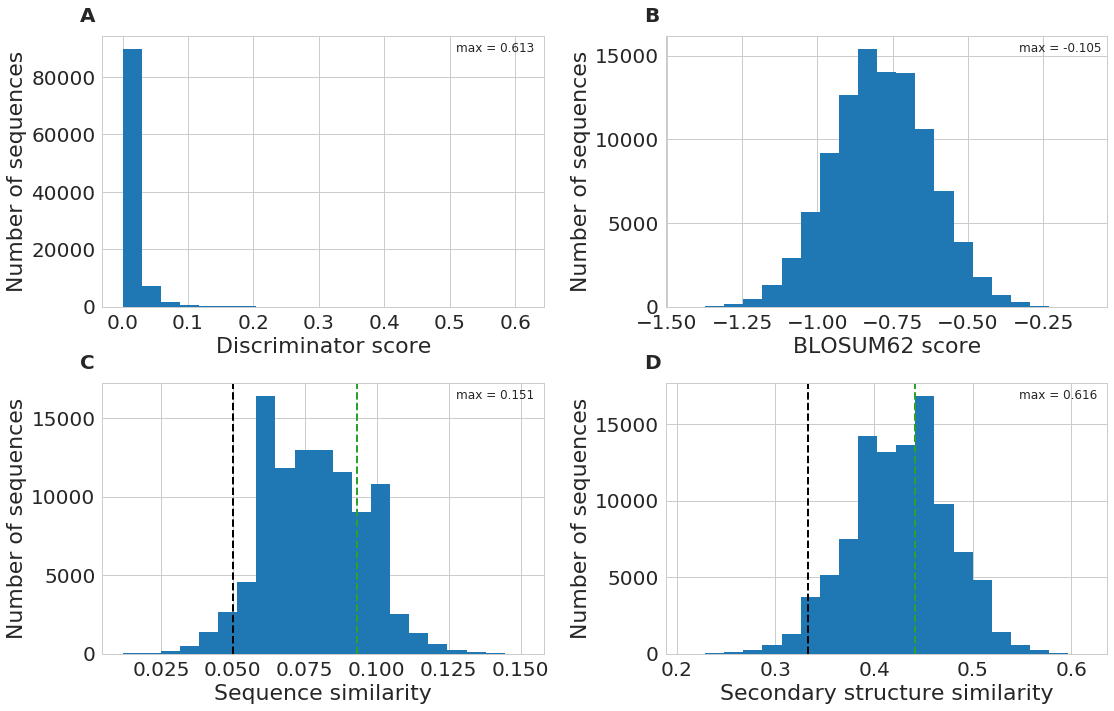

In [699]:
fg, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.flat

data = [
    ('discriminator_score', 'Discriminator score'),
    ('blosum62_score', 'BLOSUM62 score'),
    ('edit_score', 'Sequence similarity'),
    ('ss_edit_score', 'Secondary structure similarity'),
]

for i, (name, xlabel) in enumerate(data):
    ax = axs[i]
    plt.sca(ax)
    plt.hist(predictions[name].values, bins=21)
    plt.xlabel(xlabel)
    plt.ylabel("Number of sequences")
    plt.text(-0.05, 1.05, string.ascii_uppercase[i], transform=ax.transAxes, size=20, weight='bold')
    plt.text(0.80, 0.94, f'max = {predictions[name].max():.3f}', transform=ax.transAxes, size=12)
    if name == 'edit_score':
        mode_frac = reference['sequence'].count('A') / len(reference['sequence'])
        plt.axvline(x=1 / 20, color='k', linestyle='--', linewidth=2)
        plt.axvline(x=mode_frac, color='C2', linestyle='--', linewidth=2)
    elif name == 'ss_edit_score':
        mode_frac = reference['sequence_ss'].count('H') / len(reference['sequence_ss'])
        plt.axvline(x=1/3, color='k', linestyle='--', linewidth=2)
        plt.axvline(x=mode_frac, color='C2', linestyle='--', linewidth=2)
    
plt.tight_layout()

plt.savefig(f'{NOTEBOOK_PATH}/generated_sequence_statistics.pdf', bbox_inches='tight')
plt.savefig(f'{NOTEBOOK_PATH}/generated_sequence_statistics.png', dpi=300, bbox_inches='tight')

## Secondary structure consensus

In [700]:
def write_weblogo(seqs, basename, color_scheme='hydrophobicity'):
    pagnn.utils.make_weblogo(
        seqs, units='probability', color_scheme=color_scheme,
        format_='pdf', output_file=basename.with_suffix('.pdf'))
    img = pagnn.utils.make_weblogo(
        seqs, units='probability', color_scheme=color_scheme,
        format_='png_print', output_file=basename.with_suffix('.png'))
    return img

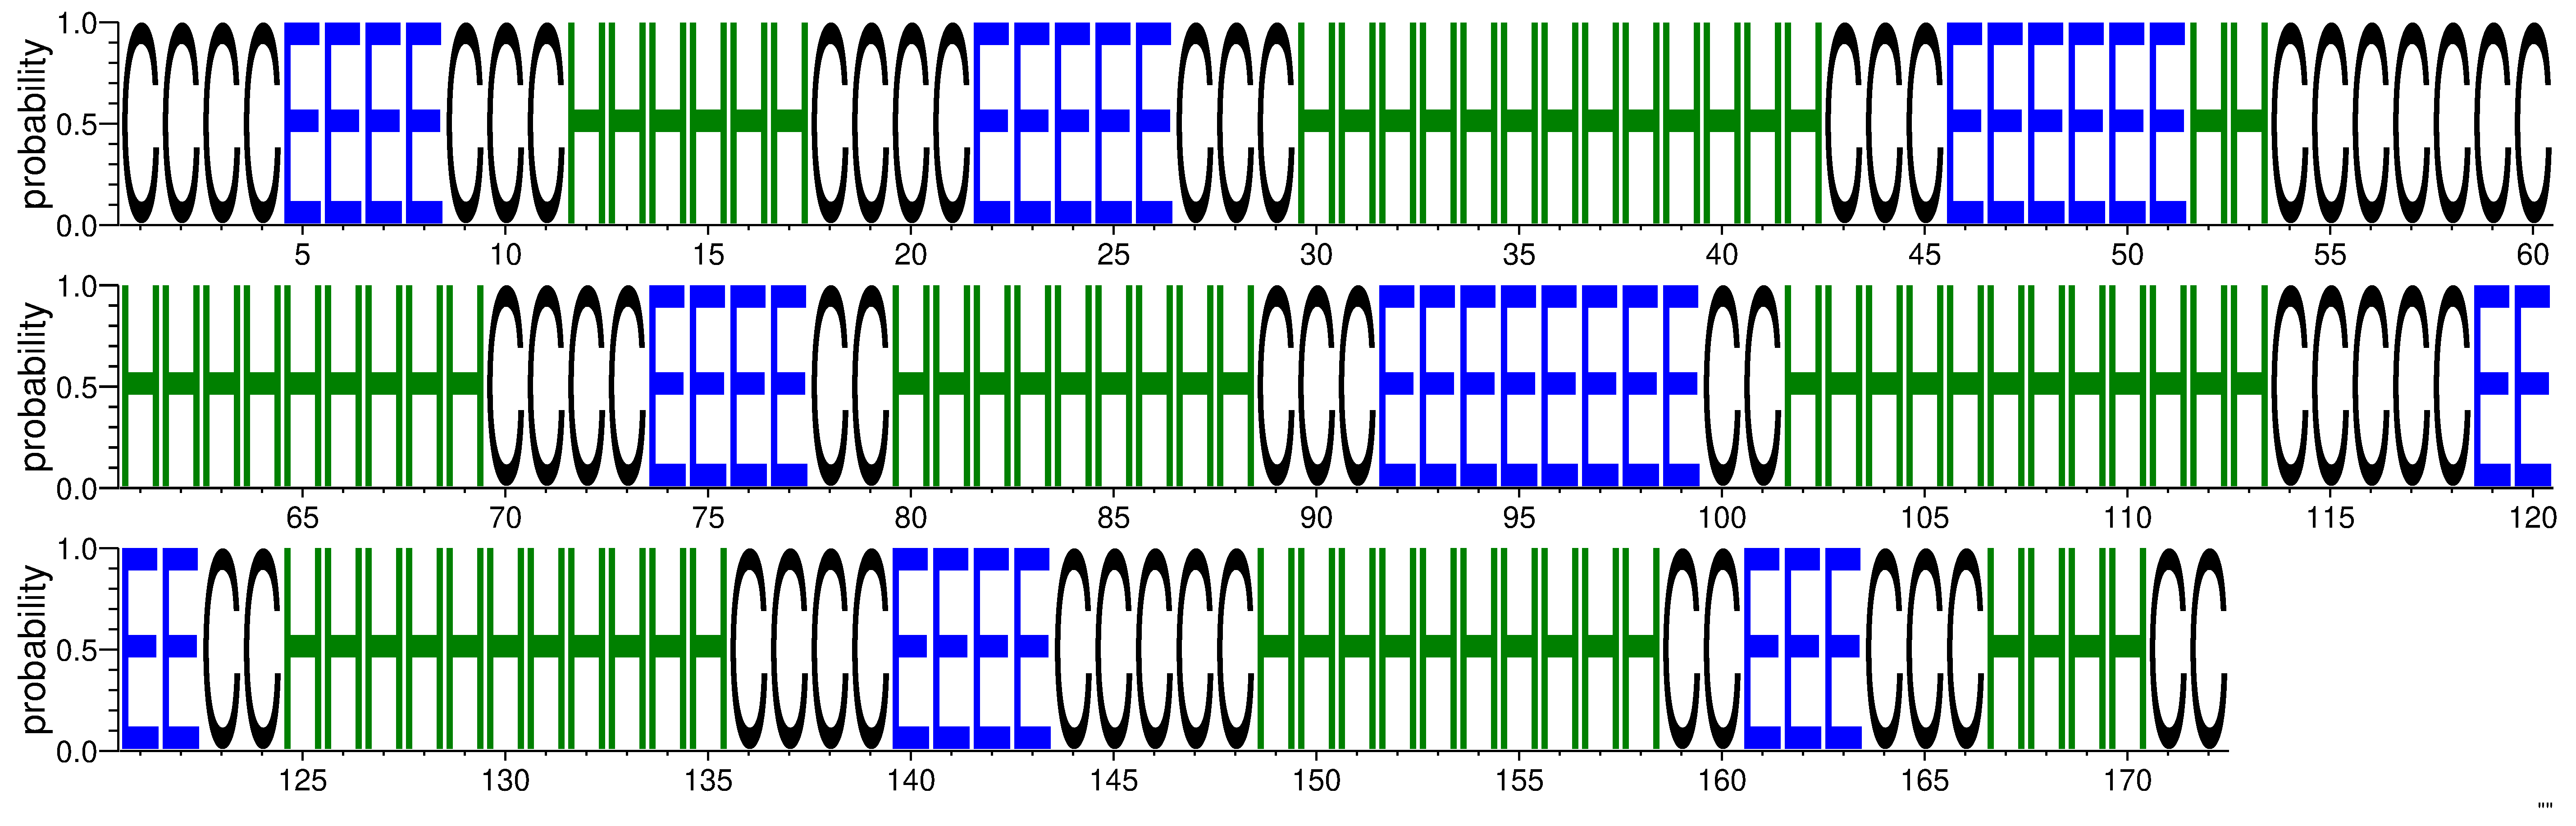

In [701]:
write_weblogo(
    [reference['sequence_ss']],
    NOTEBOOK_PATH.joinpath('ss_ref_weblogo'),
)

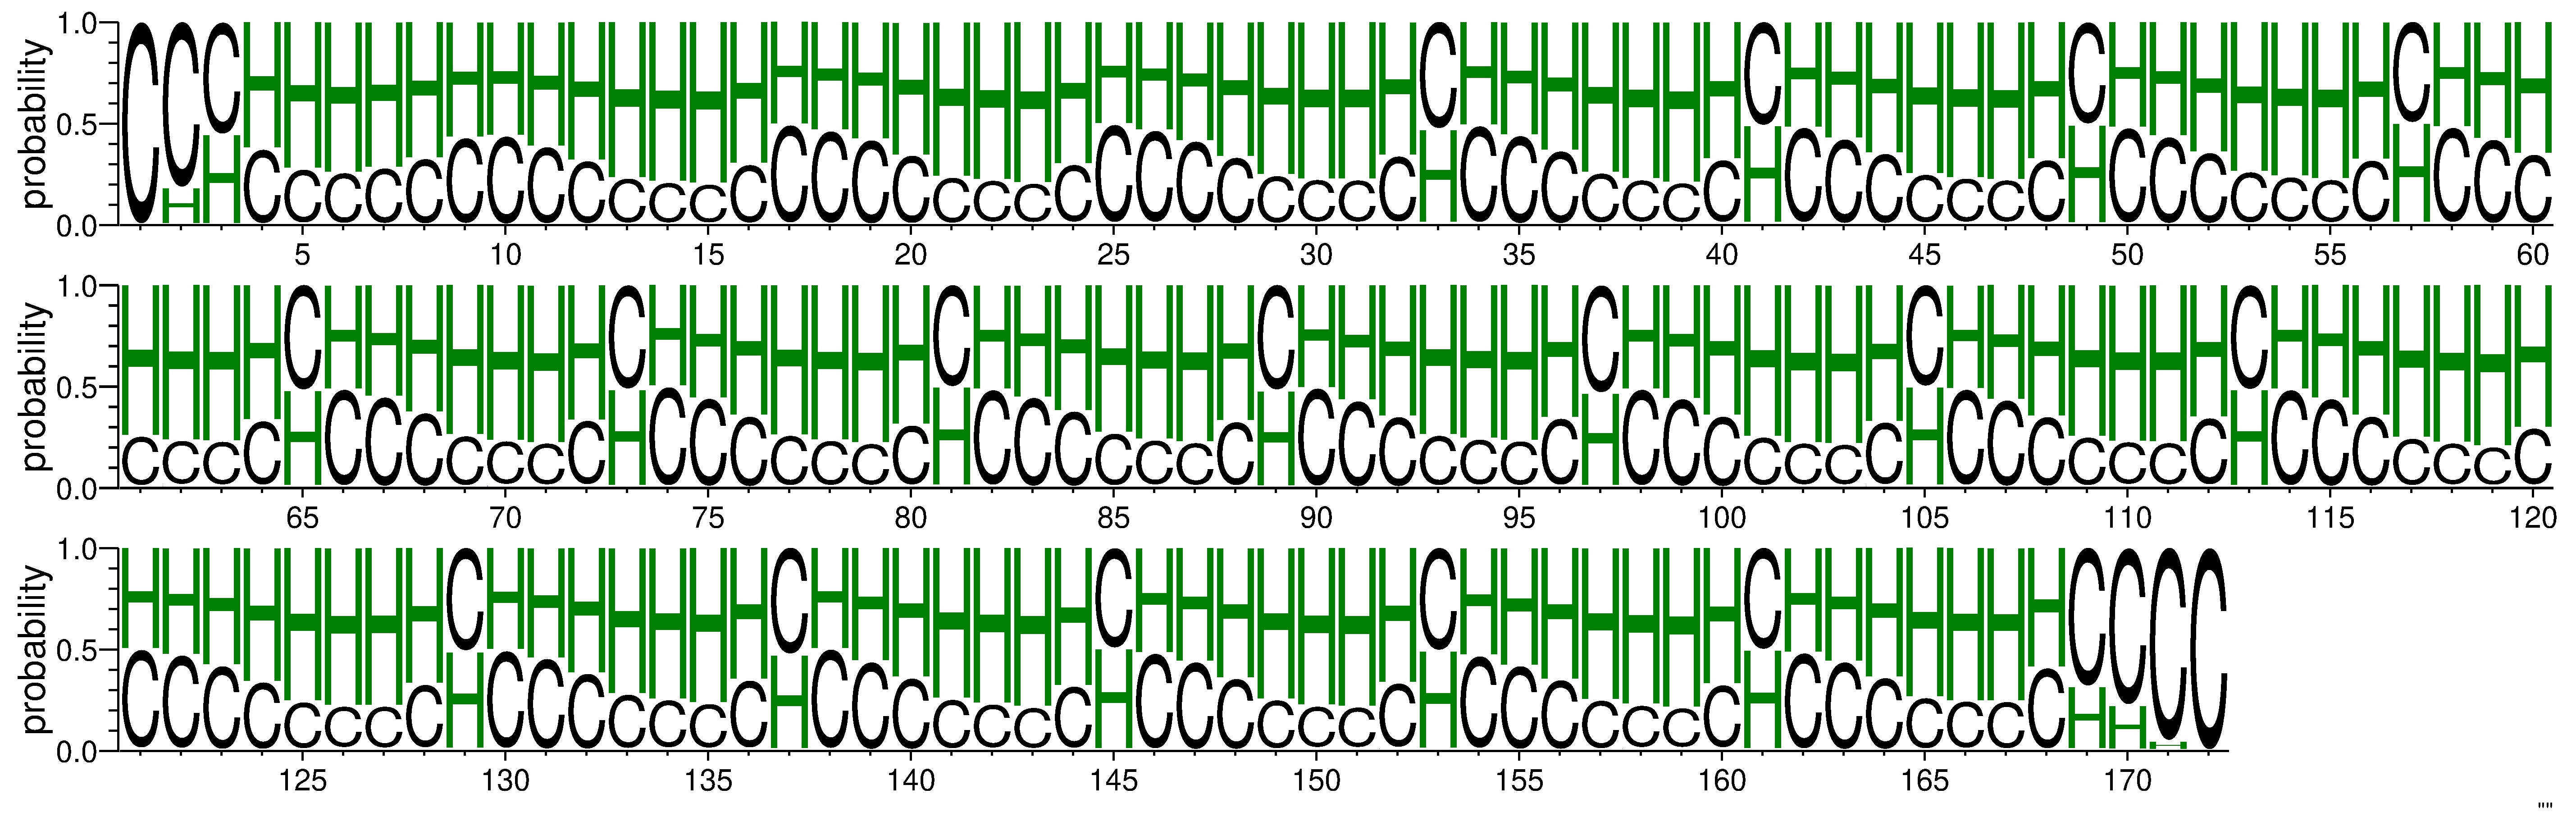

In [702]:
write_weblogo(
    predictions['sequence_ss'].values.tolist(),
    NOTEBOOK_PATH.joinpath('ss_gen_weblogo'),
)

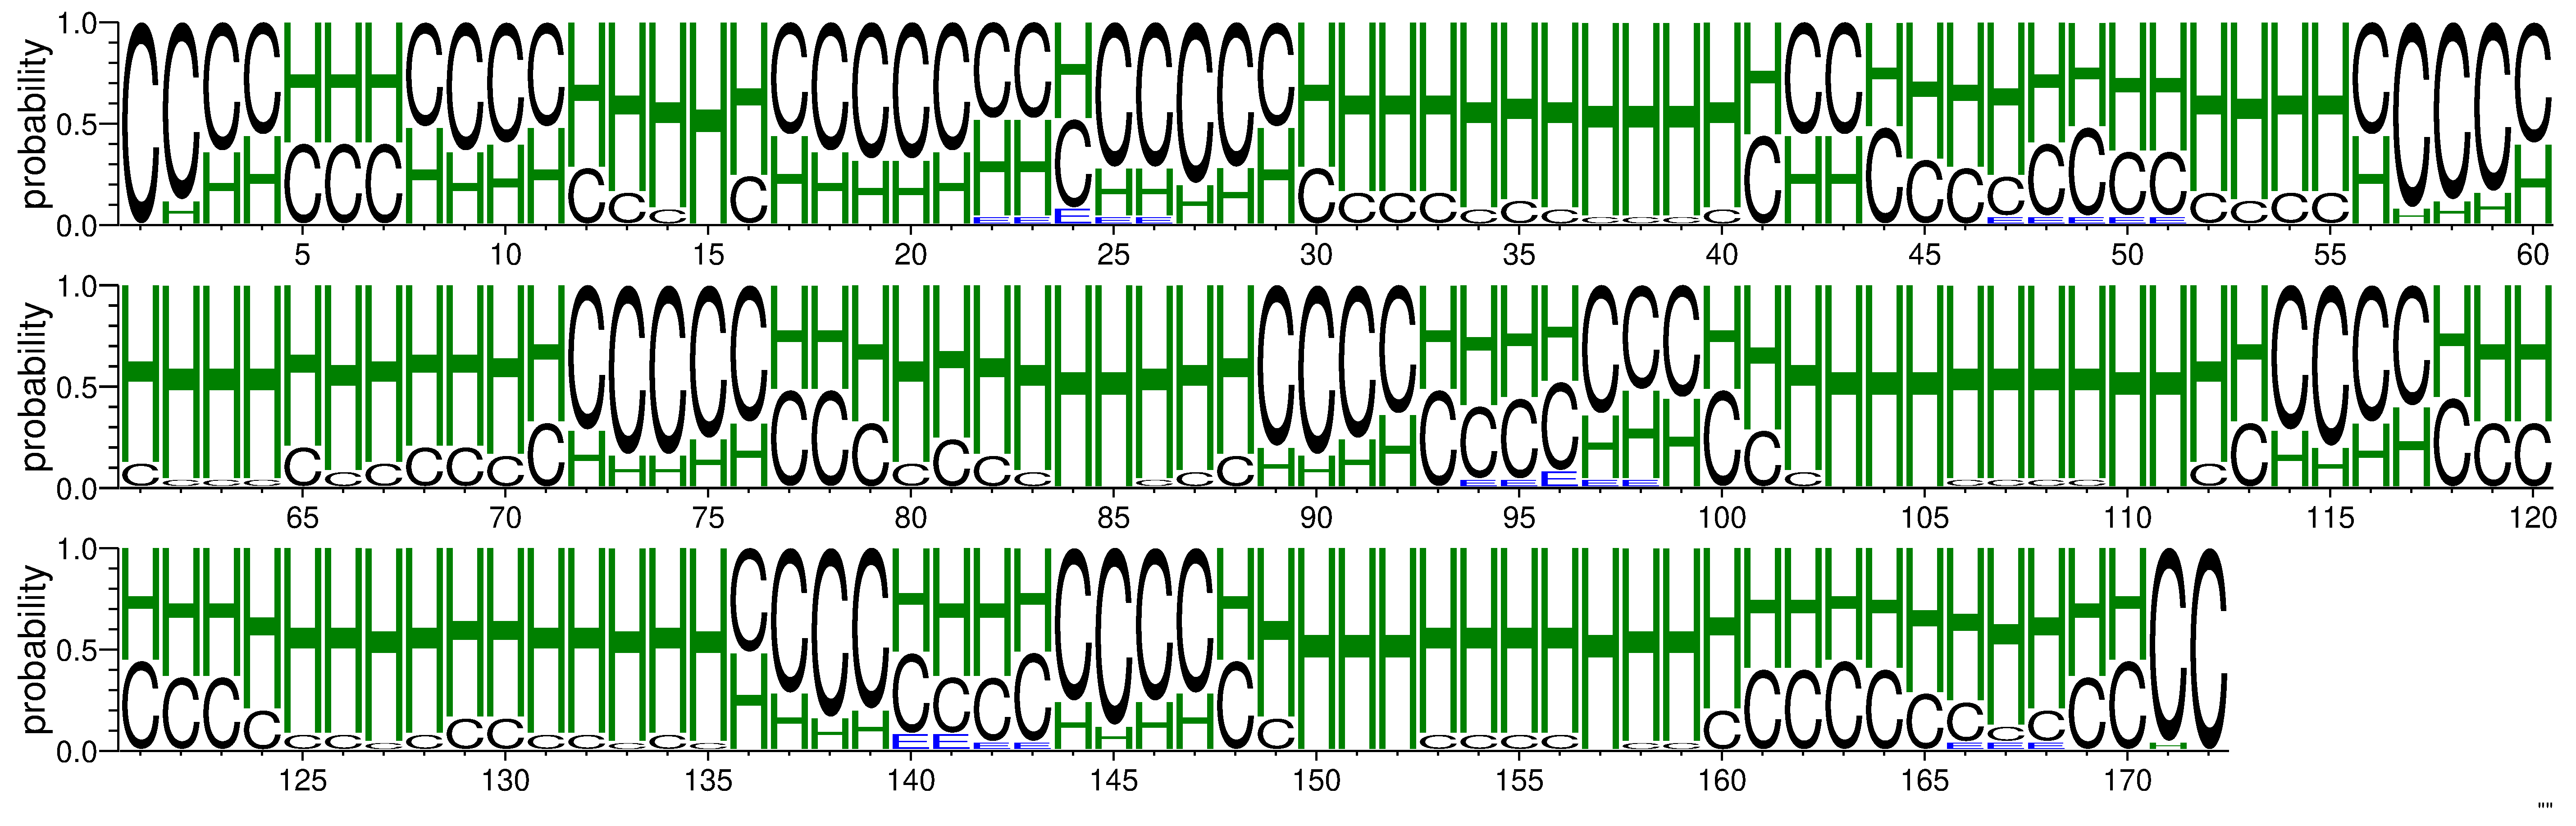

In [703]:
write_weblogo(
    predictions \
        .sort_values('ss_edit_score', ascending=False).iloc[:25] \
        ['sequence_ss'].values.tolist(),
    NOTEBOOK_PATH.joinpath('ss_gen_top25_weblogo'),
)

In [712]:
# Load hhblits psipreds
seqs = list(Bio.SeqIO.parse(f'{NOTEBOOK_NAME}/1vkf0A.ss.fasta', format='fasta'))

seq_ref = str(seqs[0].seq)
seqs_target = [str(s.seq) for s in seqs[1:]]

seqs_target = [''.join(st for sr, st in zip(seq_ref, s) if sr != '-') for s in seqs_target]
seq_ref = ''.join(s for s in seq_ref if s != '-')

assert all(len(s) == len(seq_ref) for s in seqs_target)

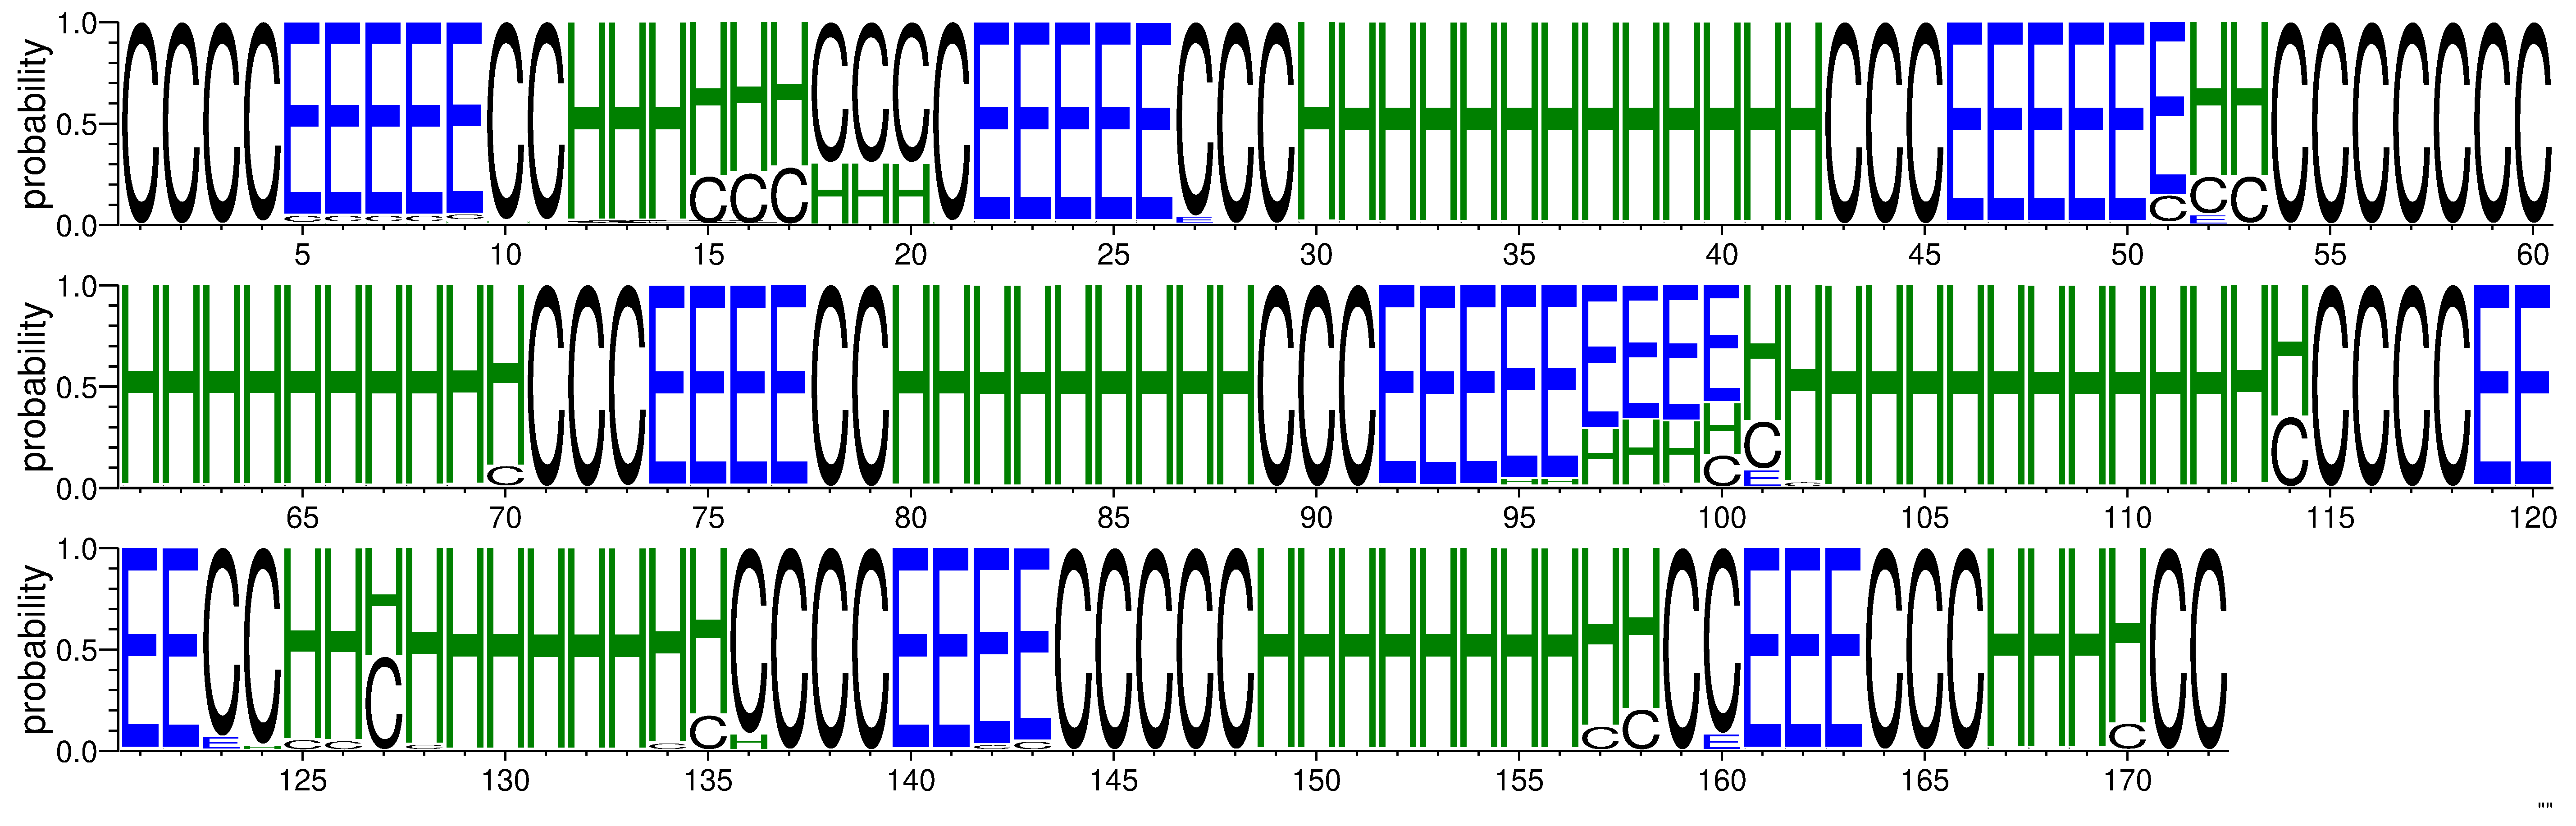

In [715]:
write_weblogo(
    seqs_target,
    NOTEBOOK_PATH.joinpath('ss_ref_hhblits_weblogo'),
)

## Sequence consensus

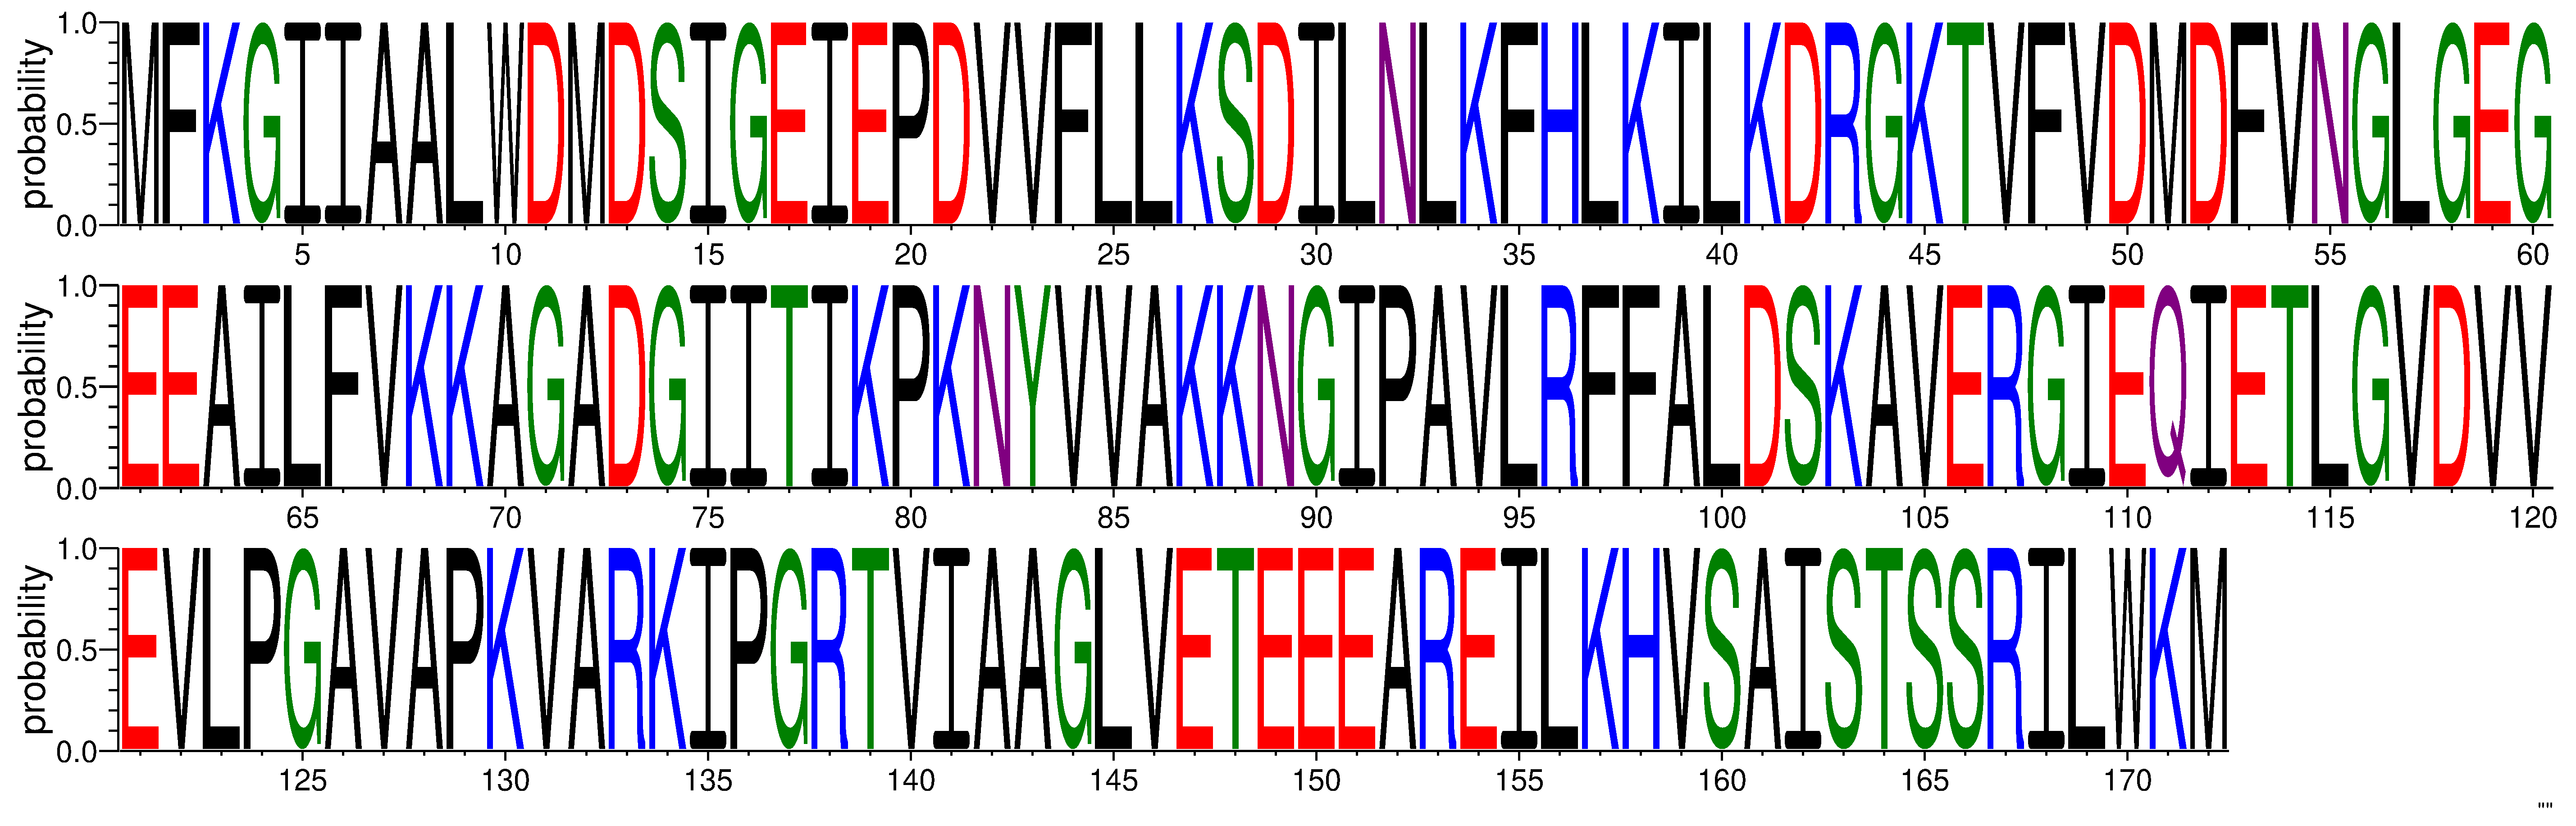

In [704]:
write_weblogo(
    [reference['sequence']], 
    NOTEBOOK_PATH.joinpath('seq_ref_weblogo'),
    color_scheme='chemistry',
)

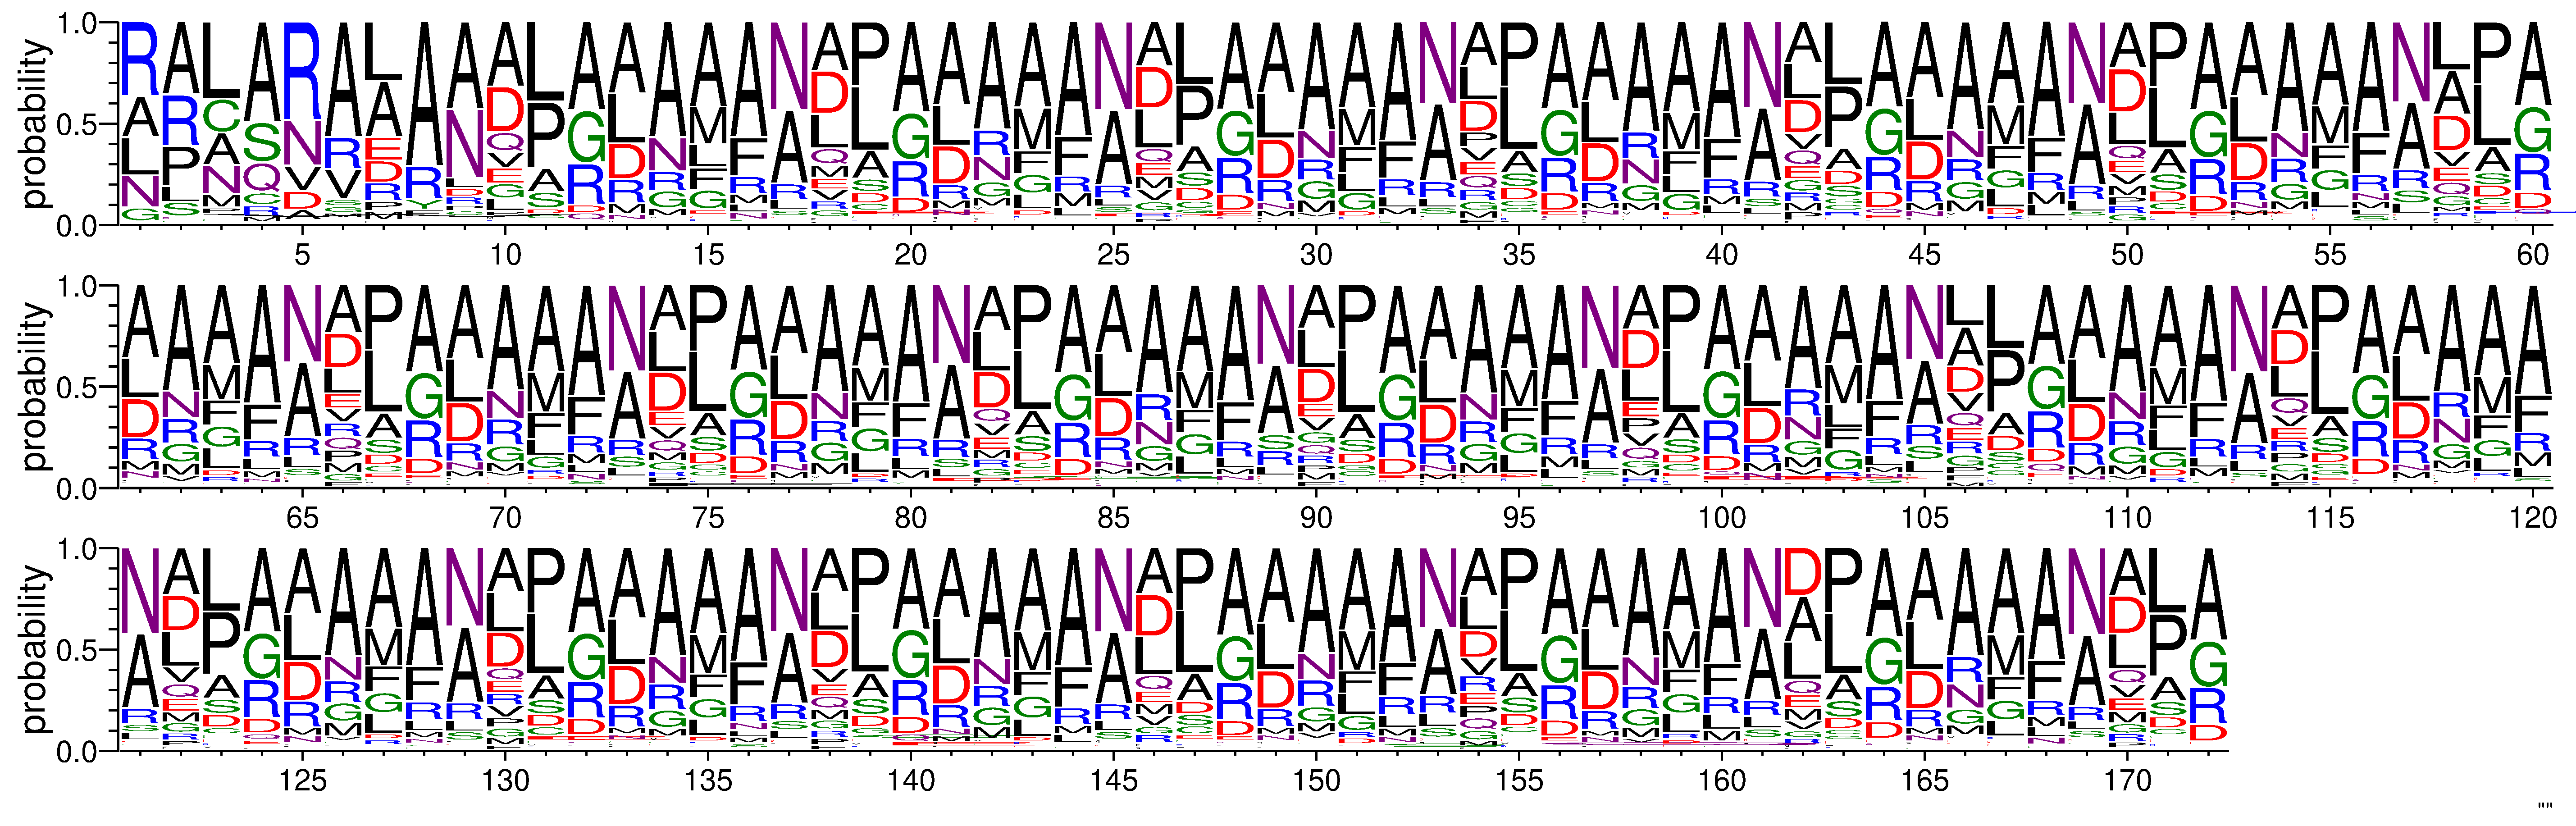

In [705]:
write_weblogo(
    predictions['sequence'].values.tolist(),
    NOTEBOOK_PATH.joinpath('seq_gen_weblogo'),
    color_scheme='chemistry',
)

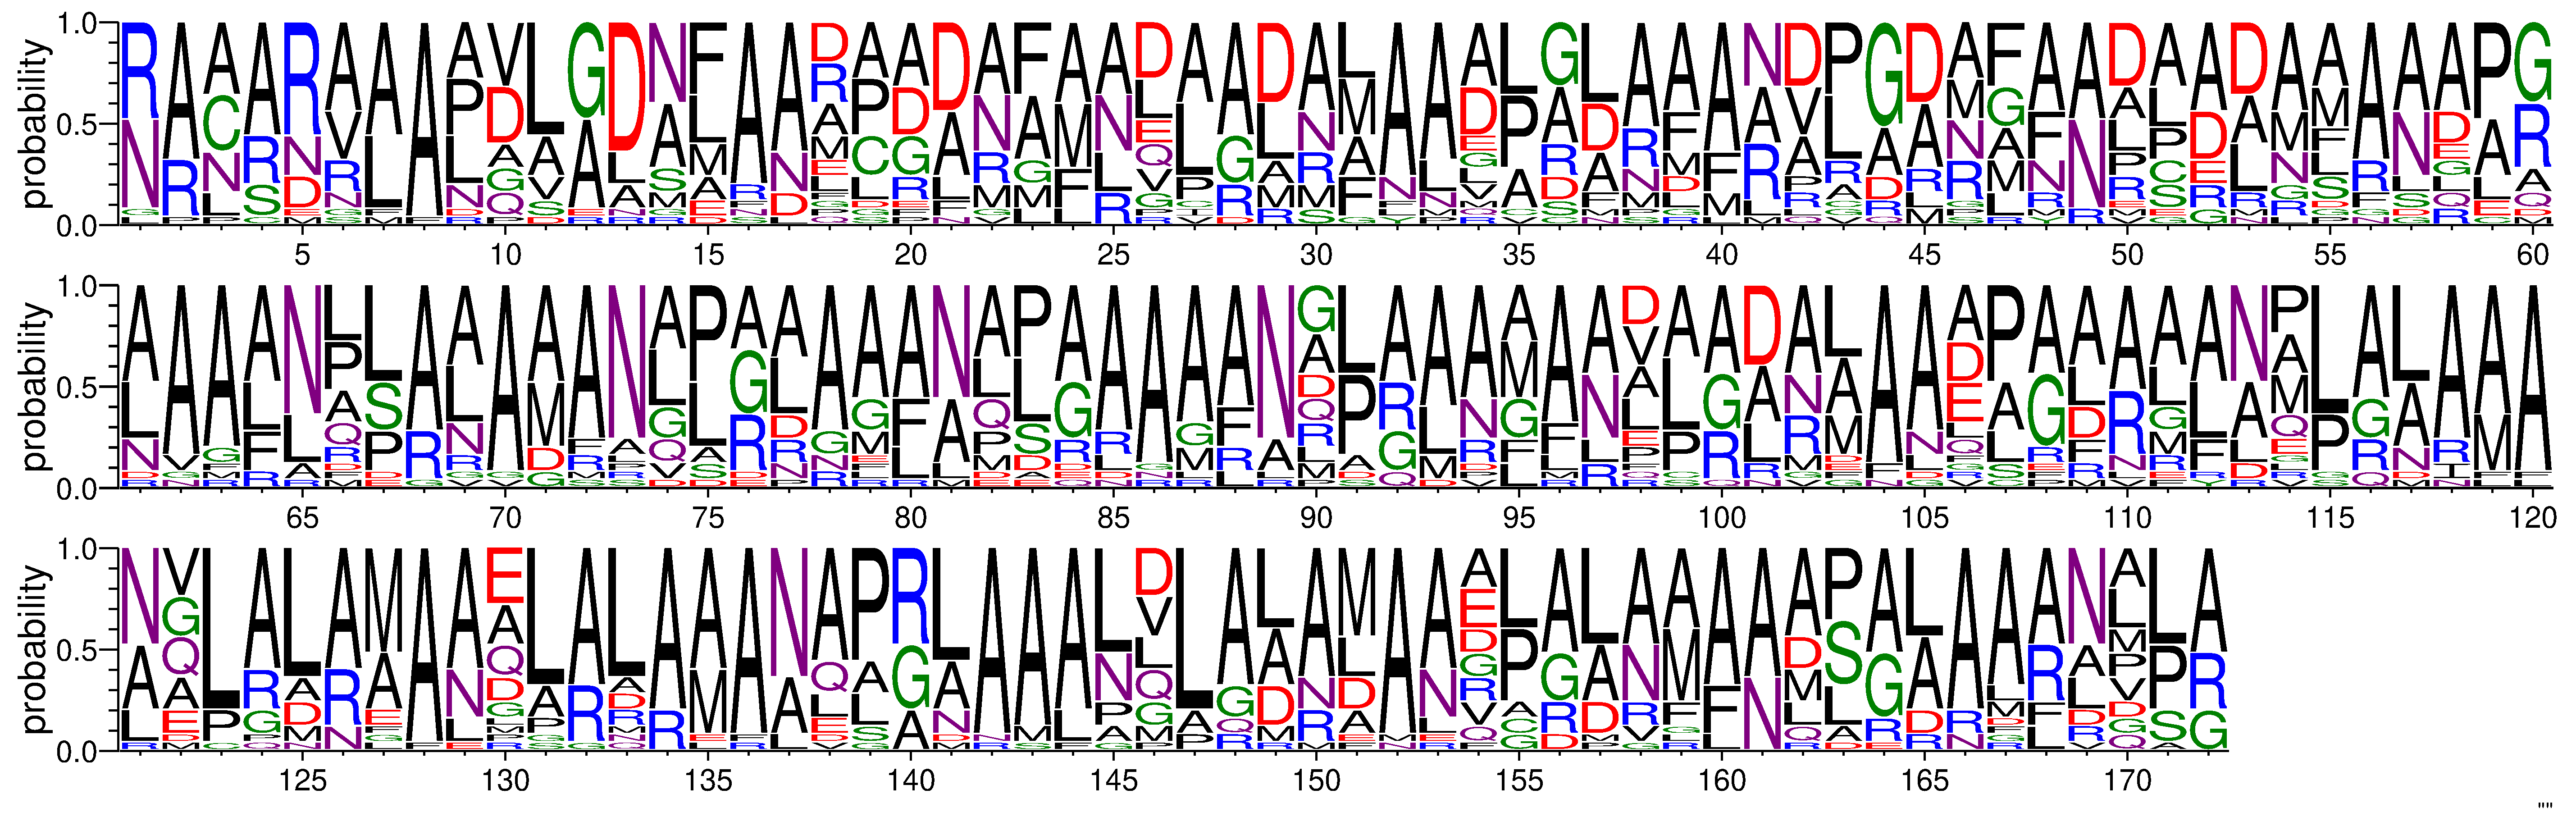

In [706]:
write_weblogo(
    predictions \
        .sort_values('edit_score', ascending=False).iloc[:25] \
        ['sequence'].values.tolist(),
    NOTEBOOK_PATH.joinpath('seq_gen_top25_weblogo'),
    color_scheme='chemistry',
)

In [707]:
# Load hhblits alignment
seqs = list(Bio.SeqIO.parse(f'{NOTEBOOK_NAME}/1vkf0A.fas', format='fasta'))

seq_ref = str(seqs[0].seq)
seqs_target = [str(s.seq) for s in seqs[1:]]

seqs_target = [''.join(st for sr, st in zip(seq_ref, s) if sr != '-') for s in seqs_target]
seq_ref = ''.join(s for s in seq_ref if s != '-')

assert all(len(s) == len(seq_ref) for s in seqs_target)

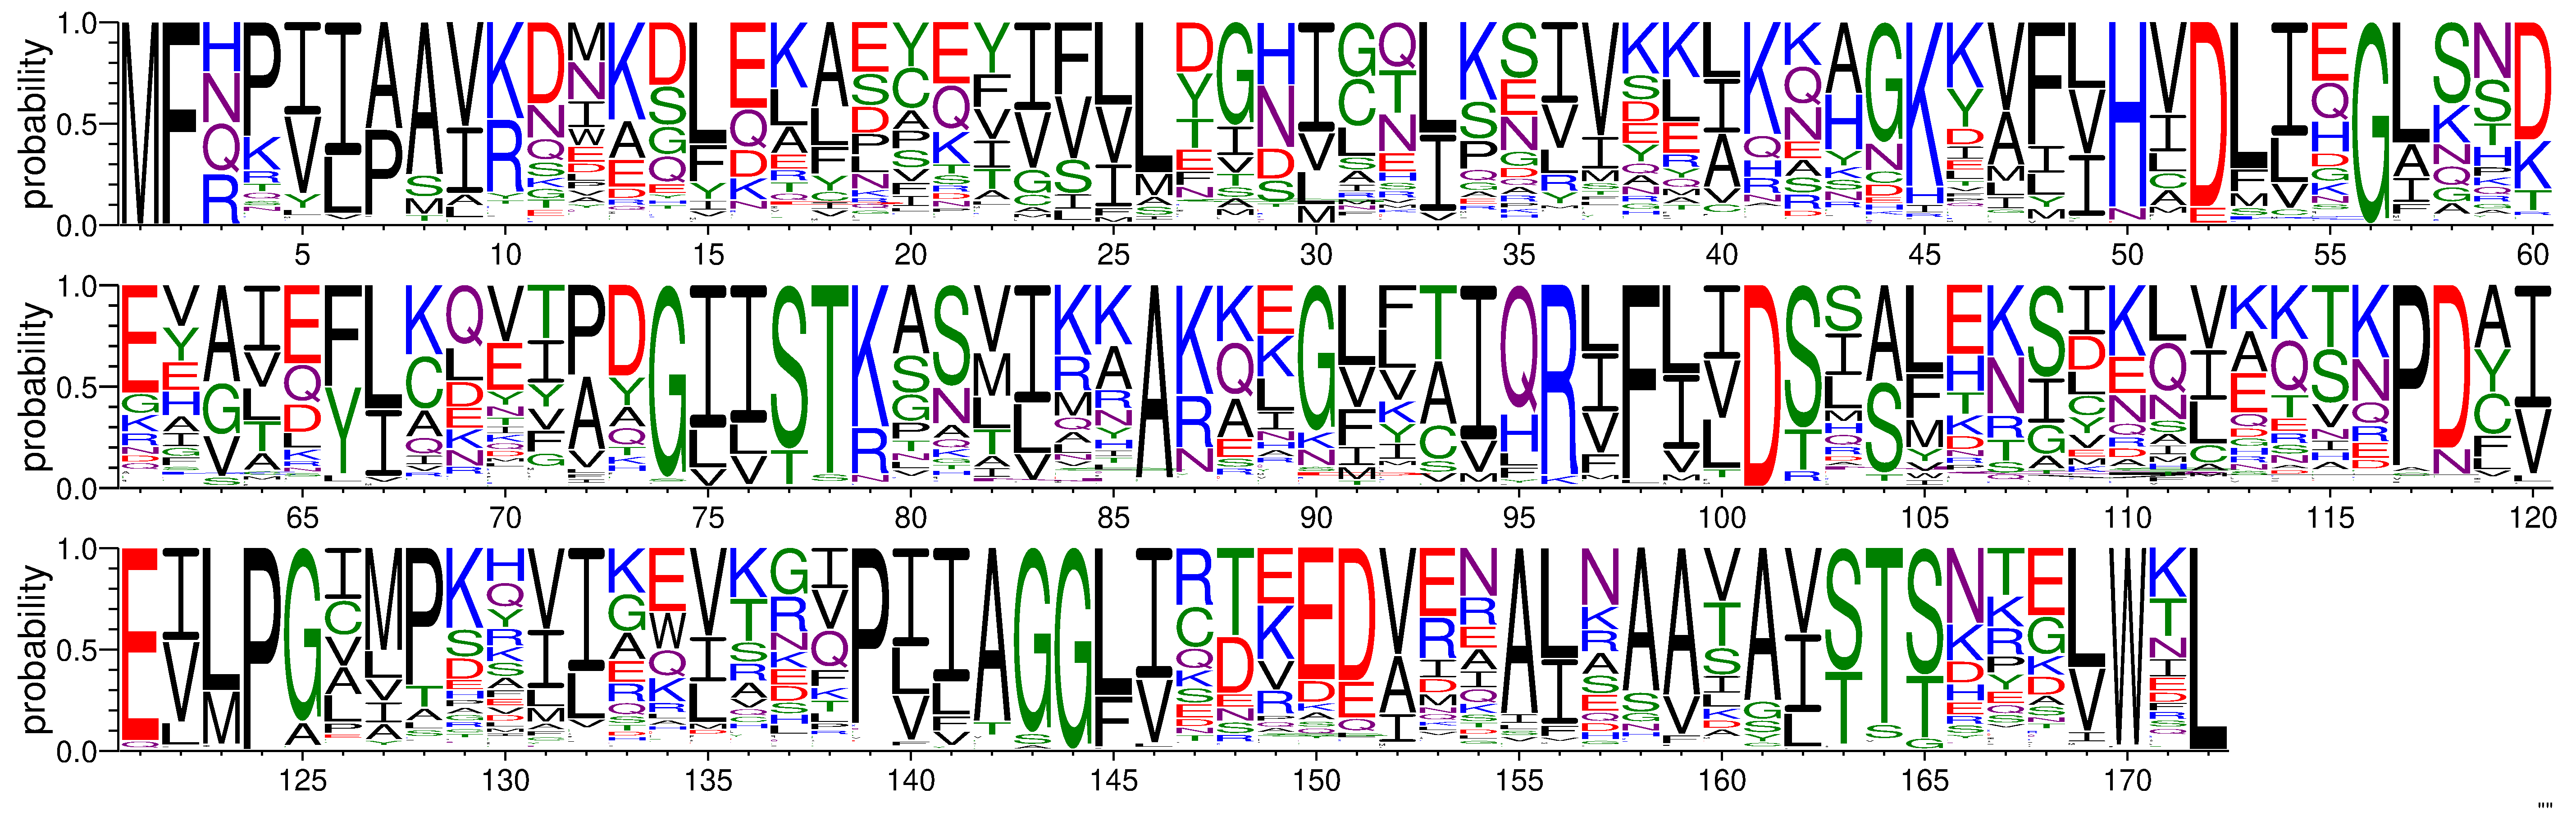

In [708]:
write_weblogo(
    seqs_target,
    NOTEBOOK_PATH.joinpath('seq_ref_hhblits_weblogo'),
    color_scheme='chemistry',
)

## I-Tasser structure prediction

In [709]:
# > validation_3-best_edit_score
predictions.sort_values('edit_score', ascending=False)['sequence'].iloc[0]

'NANARAAALQLALAEAAAPGAAALLPLALAMAAAPGLAALLDLAARLAAAPGLAAALLPRAAAALPLALAMANGLALAAAAAPGAAGLNMLQARLAAEARLAAAGDPGAAGFNMLALAMANGLADRMAADLADRMAADAADNSAAMAGLADANQPGAAALNLSAAAAANASA'

In [710]:
# > validation_3-best_ss_edit_score
predictions.sort_values('ss_edit_score', ascending=False)['sequence'].iloc[0]

'MLLANADAAAPGARALRVRGDMFADRGEDNFAADLALAMAAAPGAAGLNMLAAAMANAPGAAALLLLANAAANAPGAAALNLSANAAANLPGAAGFNPLALAMAAGLADNFAADAGDNLAAAPGLRRYDMLAAAMANAPGFRGFRVAGDMLAAEARLAAANMRRRAARNLPD'